In [250]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [273]:
npz = np.load('part1a.npz')
lst = npz.files
# for item in lst:
#     print(item)
#     print(npz[item])
N = npz['N']
SVC_0_pmf = npz['Svc_0_pmf']
Lc = npz['Lc'] 
I_v= npz['Ic_0']
gamma = npz['gamma']
R = np.zeros(1)
R[0] = 0
Z = np.zeros(21)
I = np.sum(I_v)
S__ = N - I # not sure. Do this so that the total population actually adds to 100000...
S_v_c_2 = np.multiply(SVC_0_pmf, S__) # Preserve matrix form for later...
S_v_c = S_v_c_2.flatten()
S_v_I_v_R = np.concatenate((S_v_c, I_v, R)) 
# print(S_v_c.sum(axis=0).sum(axis=0), I_v, R)

In [252]:
# Part 1 a. Chose elements for B_v,c in [0.1]

B_v_c = np.random.rand(16).reshape(4,4)
B_v_c = np.sort(B_v_c, axis = 0)
B_v_c_2 = np.sort(B_v_c, axis = 1) # Preserve matrix form for later...
B_v_c = np.array(B_v_c_2.flatten()) # Now we have elements (0,0) (0,1) (0,2) (0,3) (1,0) .... (3,3)
print(type(B_v_c))

<class 'numpy.ndarray'>


In [253]:
def susceptible_pop_eq(t, y, B_v_c):
    # y is our S_v_I_v_R vector
    # I = infected population
    # Need to get sum of dS_v_c/dt made over v. Should be a (4,1) vector
    # Sum over v. Should have column of c = 0, c= 1, c= 2, c=3
    S_vector=y[:16]
    I_vector=y[16:20]
    R=y[20]
    dSvc_dt = -(B_v_c * S_vector * I_vector.sum()/N)
    dS_v = dSvc_dt.reshape(4,4).sum(axis=0)
    dIc_dt = -(dS_v) - gamma * I_vector
    dR_dt = gamma * I_vector.sum()
    dS_dI_dr = np.concatenate((dSvc_dt, dIc_dt, [dR_dt]), axis = 0)
    return dS_dI_dr

In [254]:
sol = solve_ivp(fun = susceptible_pop_eq, t_span = (0,119,1), y0 = S_v_I_v_R, args = [B_v_c], dense_output = True)
# print(S_v_I_v_R)
# print(S_v_c)
# print(S_v_I_v_R[:16])


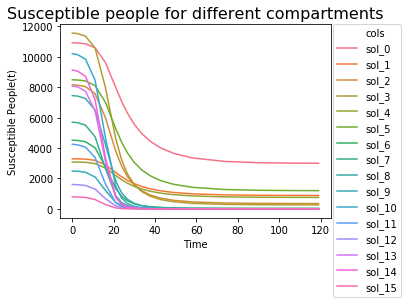

In [255]:
import seaborn as sns
# S_v_c values over time, 

df1 = pd.DataFrame()
df1.insert(0, "Time", sol.t)
for i in range(16):
    df1.insert(i+1, "sol_{}".format(i), sol.y[i])

df1 = df1.melt("Time", var_name='cols', value_name='Susceptible People(t)')
sns.lineplot(x = "Time", y = "Susceptible People(t)", hue="cols", data=df1)
plt.legend(bbox_to_anchor=(1.26, 1),borderaxespad=0)
plt.title("Susceptible people for different compartments", fontsize = 16)
plt.tight_layout()

(22,)


Text(0.5, 1.0, 'Infected people for different comorbidity compartments')

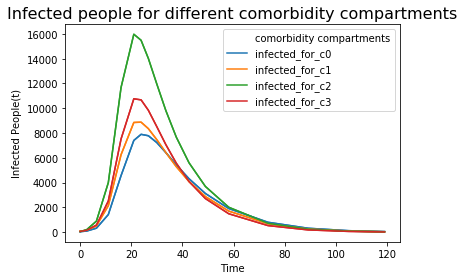

In [256]:
import seaborn as sns
print(sol.y[0].shape)
for i in range(16,20):
    sns.lineplot(sol.t, sol.y[i])
df2 = pd.DataFrame()
df2.insert(0, "Time", sol.t)
for i in range(16,20):
    df2.insert(i-15, "infected_for_c{}".format(i-16), sol.y[i])

df2 = df2.melt("Time", var_name='comorbidity compartments', value_name='Infected People(t)')
sns.lineplot(x = "Time", y = "Infected People(t)", hue="comorbidity compartments", data=df2)
plt.title("Infected people for different comorbidity compartments", fontsize=16)

Text(0, 0.5, 'Susceptible People (t)')

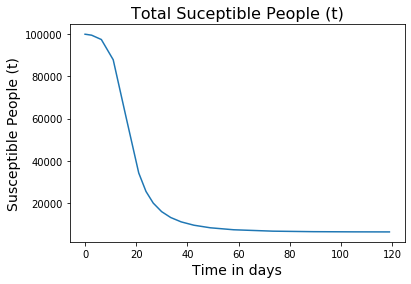

In [257]:
# Plot overall susceptible people
df_total = pd.DataFrame()
df_total.insert(0, "Time", sol.t)
for i in range(16):
    df_total.insert(i+1, "sol_{}".format(i), sol.y[i])
df_total["sum"] = df_total.iloc[:,1:].sum(axis=1)
sns.lineplot(df_total["Time"], df_total["sum"])
plt.title("Total Suceptible People (t)", fontsize=16)
plt.xlabel('Time in days', fontsize=14)
plt.ylabel('Susceptible People (t)', fontsize=14)

(22,)


Text(0, 0.5, 'Infected People (t)')

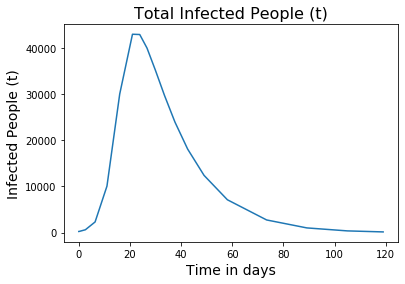

In [258]:
# Plot overall infected people
# Test this one
print(sol.y[0].shape)
df2_total = pd.DataFrame()
df2_total.insert(0, "Time", sol.t)
for i in range(16,20):
    df2_total.insert(i-15, "infected_for_c{}".format(i-16), sol.y[i])
df2_total["sum"] = df2_total.iloc[:,1:].sum(axis=1)
sns.lineplot(df2_total["Time"], df2_total["sum"])
plt.title("Total Infected People (t)", fontsize=16)
plt.xlabel('Time in days', fontsize=14)
plt.ylabel('Infected People (t)', fontsize=14)

Text(0, 0.5, 'Recovered People (t)')

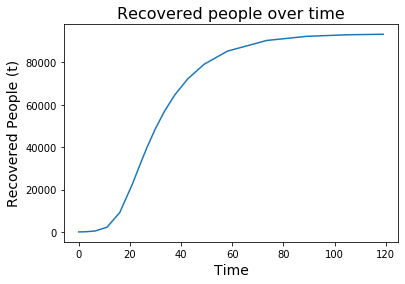

In [259]:
# Recovered people over time
sns.lineplot(sol.t, sol.y[20])
plt.title("Recovered people over time", fontsize = 16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Recovered People (t)', fontsize=14)

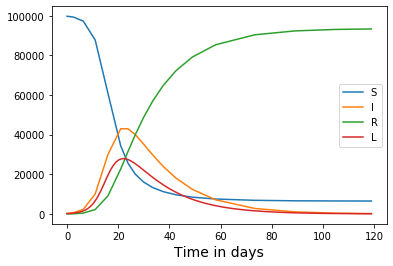

In [260]:
t = np.linspace(0,119,120)
L_total = Lc * sol.sol(t).T[:,16:20]
Lt = sum(L_total.T)
Lt

plt.plot(sol.t, sum(sol.y[:16]), label = 'S')
plt.plot(sol.t, sum(sol.y[16:20]), label = 'I')
plt.plot(sol.t, sol.y[20], label = 'R')
plt.plot(t, Lt, label = 'L')

plt.xlabel('Time in days', fontsize=14)
plt.legend()
plt.show()

3) The plots definitely look similar to what we expected. When people refer to flattening the curve, they refer to the infected people curve. Flattening it is of utmost importance so that we don't put too much strain on the health system and people can actually get treated!

4) Yes, as we can see in some situations the susceptible people converge to 0 and in others it doesn't. This has to do with the ability of the virus to spread. In some situations, the virus will keep spreading until there is no susceptible people. this could happen in situations where there people don't use a mask, there is no social distancing, and there is more social vulnerability and comorbidity. If the virus can't spread that easily because many of this measures are in place, then it won't be able to infect everyone and the susceptible people won't converge to 0. In our model these changes come from the compartments of social vulnerability and comorbidity. The more vulnerable people are, for example, the more chances that they all get infected and thus that the susceptible people converge to 0.

In [261]:
# Print percentages of population that never got infected for all compartments (5)
# That corresponds to the last row of the susceptible people data frame (susceptible people at day 120!)
percentages_non_infected = df_total.iloc[-1, :][1:-1]/S_v_c
for number, value in enumerate(percentages_non_infected):
    print("Compartment", number, ':', value, '%')

Compartment 0 : 0.2745119065363422 %
Compartment 1 : 0.2677625067506939 %
Compartment 2 : 0.042789147782727674 %
Compartment 3 : 0.022624876663842147 %
Compartment 4 : 0.24438051387653353 %
Compartment 5 : 0.14111764469027627 %
Compartment 6 : 0.006564482276171549 %
Compartment 7 : 0.00042482894037814794 %
Compartment 8 : 0.003042350091139737 %
Compartment 9 : 0.0006704668363112145 %
Compartment 10 : 0.00035963901043448875 %
Compartment 11 : 6.037761568835588e-05 %
Compartment 12 : 0.00015151442774607513 %
Compartment 13 : 6.44128086012008e-05 %
Compartment 14 : 3.896406279895351e-05 %
Compartment 15 : 2.7902995353843843e-05 %


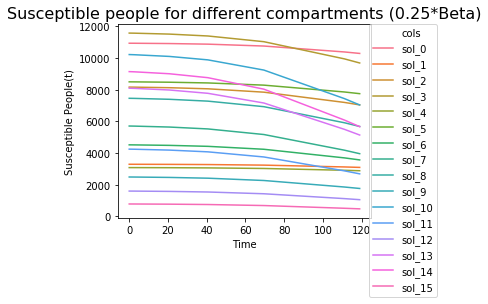

In [262]:
# Multiply all Beta values by 1/4, plot the curves, and print the population 
# that never got infected with these Beta values
smaller_beta = np.array(B_v_c_2 * 0.25).flatten()
sol_smaller_beta = solve_ivp(fun = susceptible_pop_eq, t_span = (0,119), y0 = S_v_I_v_R, args = [smaller_beta], dense_output = True)

df1_smaller_beta = pd.DataFrame()
df1_smaller_beta.insert(0, "Time", sol_smaller_beta.t)
for i in range(16):
    df1_smaller_beta.insert(i+1, "sol_{}".format(i), sol_smaller_beta.y[i])

df1_smaller_beta = df1_smaller_beta.melt("Time", var_name='cols', value_name='Susceptible People(t)')
sns.lineplot(x = "Time", y = "Susceptible People(t)", hue="cols", data=df1_smaller_beta)
plt.legend(bbox_to_anchor=(1.26, 1),borderaxespad=0)
plt.title("Susceptible people for different compartments (0.25*Beta)", fontsize = 16)
plt.tight_layout()

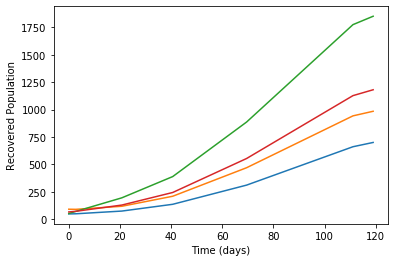

In [263]:
for i in range(16,20):
    sns.lineplot(sol_smaller_beta.t, sol_smaller_beta.y[i])
    plt.xlabel("Time (days)")
    plt.ylabel("Recovered Population")

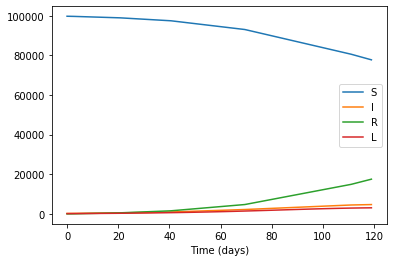

In [264]:
L_total_smaller_beta = Lc * sol_smaller_beta.sol(t).T[:,16:20]
Lt_smaller_beta = sum(L_total_smaller_beta.T)

plt.plot(sol_smaller_beta.t, sum(sol_smaller_beta.y[:16]), label = 'S')
plt.plot(sol_smaller_beta.t, sum(sol_smaller_beta.y[16:20]), label = 'I')
plt.plot(sol_smaller_beta.t, sol_smaller_beta.y[20], label = 'R')
plt.plot(t, Lt_smaller_beta, label = 'L')

plt.xlabel("Time (days)")
plt.legend()
plt.show()

6) As we can see, the curves flattened a lot. This has to do with the fact that beta is the reciprocal of the typical time between contacts. Thus, if we make it smaller people will have less typical time between contacts and we will get a virus that spreads less, or that has a smaller reproduction rate. 

In [265]:
df_total_smaller_beta = pd.DataFrame()
df_total_smaller_beta.insert(0, "Time", sol_smaller_beta.t)
for i in range(16):
    df_total_smaller_beta.insert(i+1, "sol_{}".format(i), sol_smaller_beta.y[i])
df_total_smaller_beta["sum"] = df_total_smaller_beta.iloc[:,1:].sum(axis=1)
percentages_non_infected_sb = df_total_smaller_beta.iloc[-1, :][1:-1]/S_v_c
for number, value in enumerate(percentages_non_infected_sb):
    print("Compartment", number, ':', value, '%')

Compartment 0 : 0.9411011088538275 %
Compartment 1 : 0.9400015468187547 %
Compartment 2 : 0.8624256903638393 %
Compartment 3 : 0.8369880329105945 %
Compartment 4 : 0.9359765842583291 %
Compartment 5 : 0.9121468960461825 %
Compartment 6 : 0.7897007737909018 %
Compartment 7 : 0.6942284037980222 %
Compartment 8 : 0.7616532408431891 %
Compartment 9 : 0.7093189369524953 %
Compartment 10 : 0.6887961949351727 %
Compartment 11 : 0.6330431591819606 %
Compartment 12 : 0.6612481943408844 %
Compartment 13 : 0.634990852346449 %
Compartment 14 : 0.6199910591422005 %
Compartment 15 : 0.6101907373374218 %


In [311]:
# Part 1b
data_ = np.load('part1b.npz')
lst_ = data_.files

N = data_['N']
Lc = data_['Lc']
Ic_0 = data_['Ic_0']
gamma = data_['gamma']
L_validation = data_['L_validation']
L_test = data_['L_test']
betas_validation = data_['betas_validation']

In [1375]:
# print(L_validation.shape)
# np.sum(Lc * Ic_0[1])
# b_c = 0.20
# t = np.linspace(0,20,20)
# print(L_validation.shape, L_validation[0].shape)
# print(betas_validation)
# print(L_validation)

In [271]:
def susceptible_pop_eq_b_(t, y, beta0, beta1, beta2, beta3):
    S_c = y[0:4]
    I_c = y[4:8]
    R = y[8]
    beta = np.array([beta0, beta1, beta2, beta3])
    dS_dt = -beta * S_c * I_c.sum()/N # This should be a 4x1 vector
    dI_dt = -dS_dt - gamma * I_c # This is a 4x1 vector
    dR_dt = gamma * I_c.sum() # This is only a number
    dS_dI_dR = np.concatenate((dS_dt, dI_dt, [dR_dt]))
    return dS_dI_dR

In [1377]:
from sklearn.metrics import mean_squared_error
from itertools import product
# Gridsearch
# We want to estimate beta 
# We will try different values of beta and see which one fits better the data
# How? We find I_c and then for each node find L_estimated and compare it with L_validation
def beta_grid_search(Sc_pmf, L_observed, Ic_0, N, Lc, gamma):
    beta_grid = np.linspace(0,1,21)
    t = np.linspace(0,19,20)
    beta_mmse = np.inf
#     Sc_pmf = np.array([0.5, 0.3, 0.1, 0.1]) # We will solve beta for leaf nodes with vulnerability 0.2
    R_0 = 0
    for (beta0, beta1, beta2, beta3) in product(beta_grid, beta_grid, beta_grid, beta_grid):
        if not (beta0 <= beta1 <= beta2 <= beta3):
            continue
        L_estimated_matrix_for_5_nodes = []
        for i in range(5):
            Sc_0 = Sc_pmf * (N - Ic_0[i].sum())
            Ic_0_ = Ic_0[i] # Infected people by compartment for fist 5 nodes 
            y = np.concatenate((Sc_0, Ic_0_, [R_0])) 
            sol_object = solve_ivp(fun = susceptible_pop_eq_b_,t_span = (0,20), y0 = y, args = (beta0, beta1, beta2, beta3), dense_output = True)
            # We need the solutions I_c to compute L = sum(I_c L_c) on each day
            solutions = sol_object.sol(t) # Get solutions for 20 days
            L_estimated = []
            for sol_estimated in solutions.T:
                # We want only the Ic. This is y[4,8] in solutions
                # We want L_estimated for time series of 20 days in node i
                Ic_estimated = sol_estimated[4:8] 
                L_estimated.append(np.sum(Ic_estimated * Lc)) 

            L_estimated_matrix_for_5_nodes.append(L_estimated) # Now we have the L_estimated for the first 5 nodes

        # We are comparing time series of first 5 nodes. 
        mse = 0
        for i in range(5):
            mse += mean_squared_error(L_estimated_matrix_for_5_nodes[i], L_observed[i]) # Do mse of L estimated and L validation for each node
        if mse < beta_mmse:
            beta = [beta0, beta1, beta2, beta3] 
            beta_mmse = mse
            
    for i, value in enumerate(beta):
        beta[i] = round(beta[i], 3)
    return beta , round(beta_mmse,2)

In [1380]:
Sc_pmf_1 = np.array([0.5, 0.3, 0.1, 0.1])
Sc_pmf_2 = np.array([0.4, 0.3, 0.2, 0.1])
Sc_pmf_3 = np.array([0.3, 0.3, 0.2, 0.2])
Sc_pmf_4 = np.array([0.1, 0.2, 0.3, 0.4])
Sc_nodes = []
Sc_nodes.extend([Sc_pmf_1, Sc_pmf_2, Sc_pmf_3, Sc_pmf_4])
beta_list = []
beta_mmse_list = []
start = 0
for Sc_pmf_ in Sc_nodes:
    beta, beta_mmse = beta_grid_search(Sc_pmf_, L_validation[start:start+5], Ic_0[start:start+5], N, Lc, gamma)
    start += 5
    beta_list.append(beta)
    beta_mmse_list.append(beta_mmse)

print(beta_list, beta_mmse_list)

[[0.1, 0.15, 0.2, 0.25], [0.2, 0.25, 0.3, 0.4], [0.35, 0.45, 0.5, 0.6], [0.4, 0.5, 0.6, 0.8]] [23.71, 642.84, 33587.7, 108797.49]


In [1349]:
Sc_pmf_4 = np.array([0.1, 0.2, 0.3, 0.4])
beta_grid_search(Sc_pmf_4, L_validation[15:20], Ic_0[15:20], N, Lc, gamma)

([0.4, 0.5, 0.6, 0.8], 108797.49)

In [1339]:
print(betas_validation)

[[0.1  0.15 0.2  0.25]
 [0.2  0.25 0.3  0.4 ]
 [0.35 0.45 0.5  0.6 ]
 [0.4  0.5  0.6  0.8 ]]


In [1342]:
Sc_pmf_1 = np.array([0.5, 0.3, 0.1, 0.1])
beta_grid_search(Sc_pmf_1, L_validation[:5], Ic_0[:5], N, Lc, gamma)

([0.1, 0.15, 0.2, 0.25], 38.18)

In [1379]:
# Part 1b2
beta_list_test = []
start = 0
for Sc_pmf_ in Sc_nodes:
    beta, beta_mmse = beta_grid_search(Sc_pmf_, L_test[start:start+5], Ic_0[start:start+5], N, Lc, gamma)
    start += 5
    beta_list_test.append(beta)


print(beta_list_test)

[[0.05, 0.1, 0.15, 0.25], [0.2, 0.25, 0.3, 0.4], [0.4, 0.45, 0.5, 0.6], [0.5, 0.7, 0.7, 0.85]]


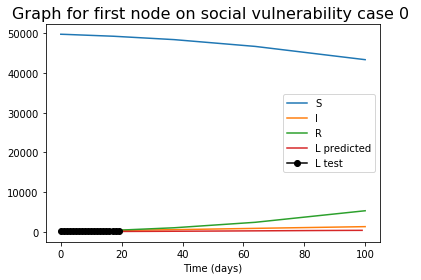

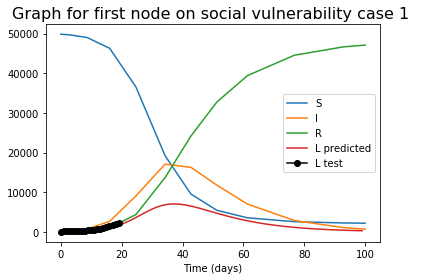

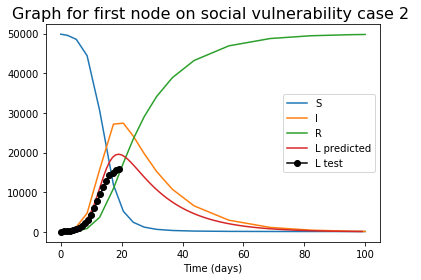

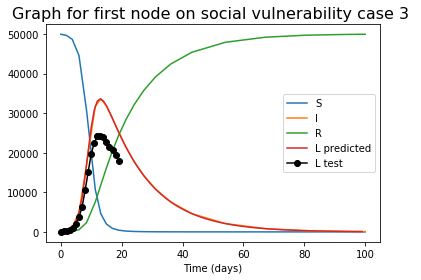

In [320]:
start = 0
counter = 0
t_ = np.linspace(0,99,100)
for Sc_pmf, beta_list in zip(Sc_nodes, beta_list_test):
    Sc_0 = Sc_pmf * (N - Ic_0[start].sum())
    Ic_0_ = Ic_0[start] # Infected people by compartment for fist 5 nodes 
    y = np.concatenate((Sc_0, Ic_0_, [R_0]))
    sol_object = solve_ivp(fun = susceptible_pop_eq_b_,t_span = (0,100), y0 = y, args = (beta_list[0], beta_list[1], beta_list[2], beta_list[3]), dense_output = True)
    L_total_smaller_beta = Lc[counter] * sol_object.sol(t_).T[:,4:8]
    Lt_predicted = sum(L_total_smaller_beta.T)

    plt.plot(sol_object.t, sum(sol_object.y[:4]), label = 'S')
    plt.plot(sol_object.t, sum(sol_object.y[4:8]), label = 'I')
    plt.plot(sol_object.t, sol_object.y[8], label = 'R')
    plt.plot(t_, Lt_predicted, label = 'L predicted')
    plt.plot(np.linspace(0,19,20), L_test[start], marker = "o" ,label = 'L test', color="black")
    plt.xlabel("Time (days)")
    plt.title("Graph for first node on social vulnerability case {} ".format(counter), fontsize = 16)
    plt.legend()
    plt.show()
    start += 5
    counter +=1 
